Link to paper : 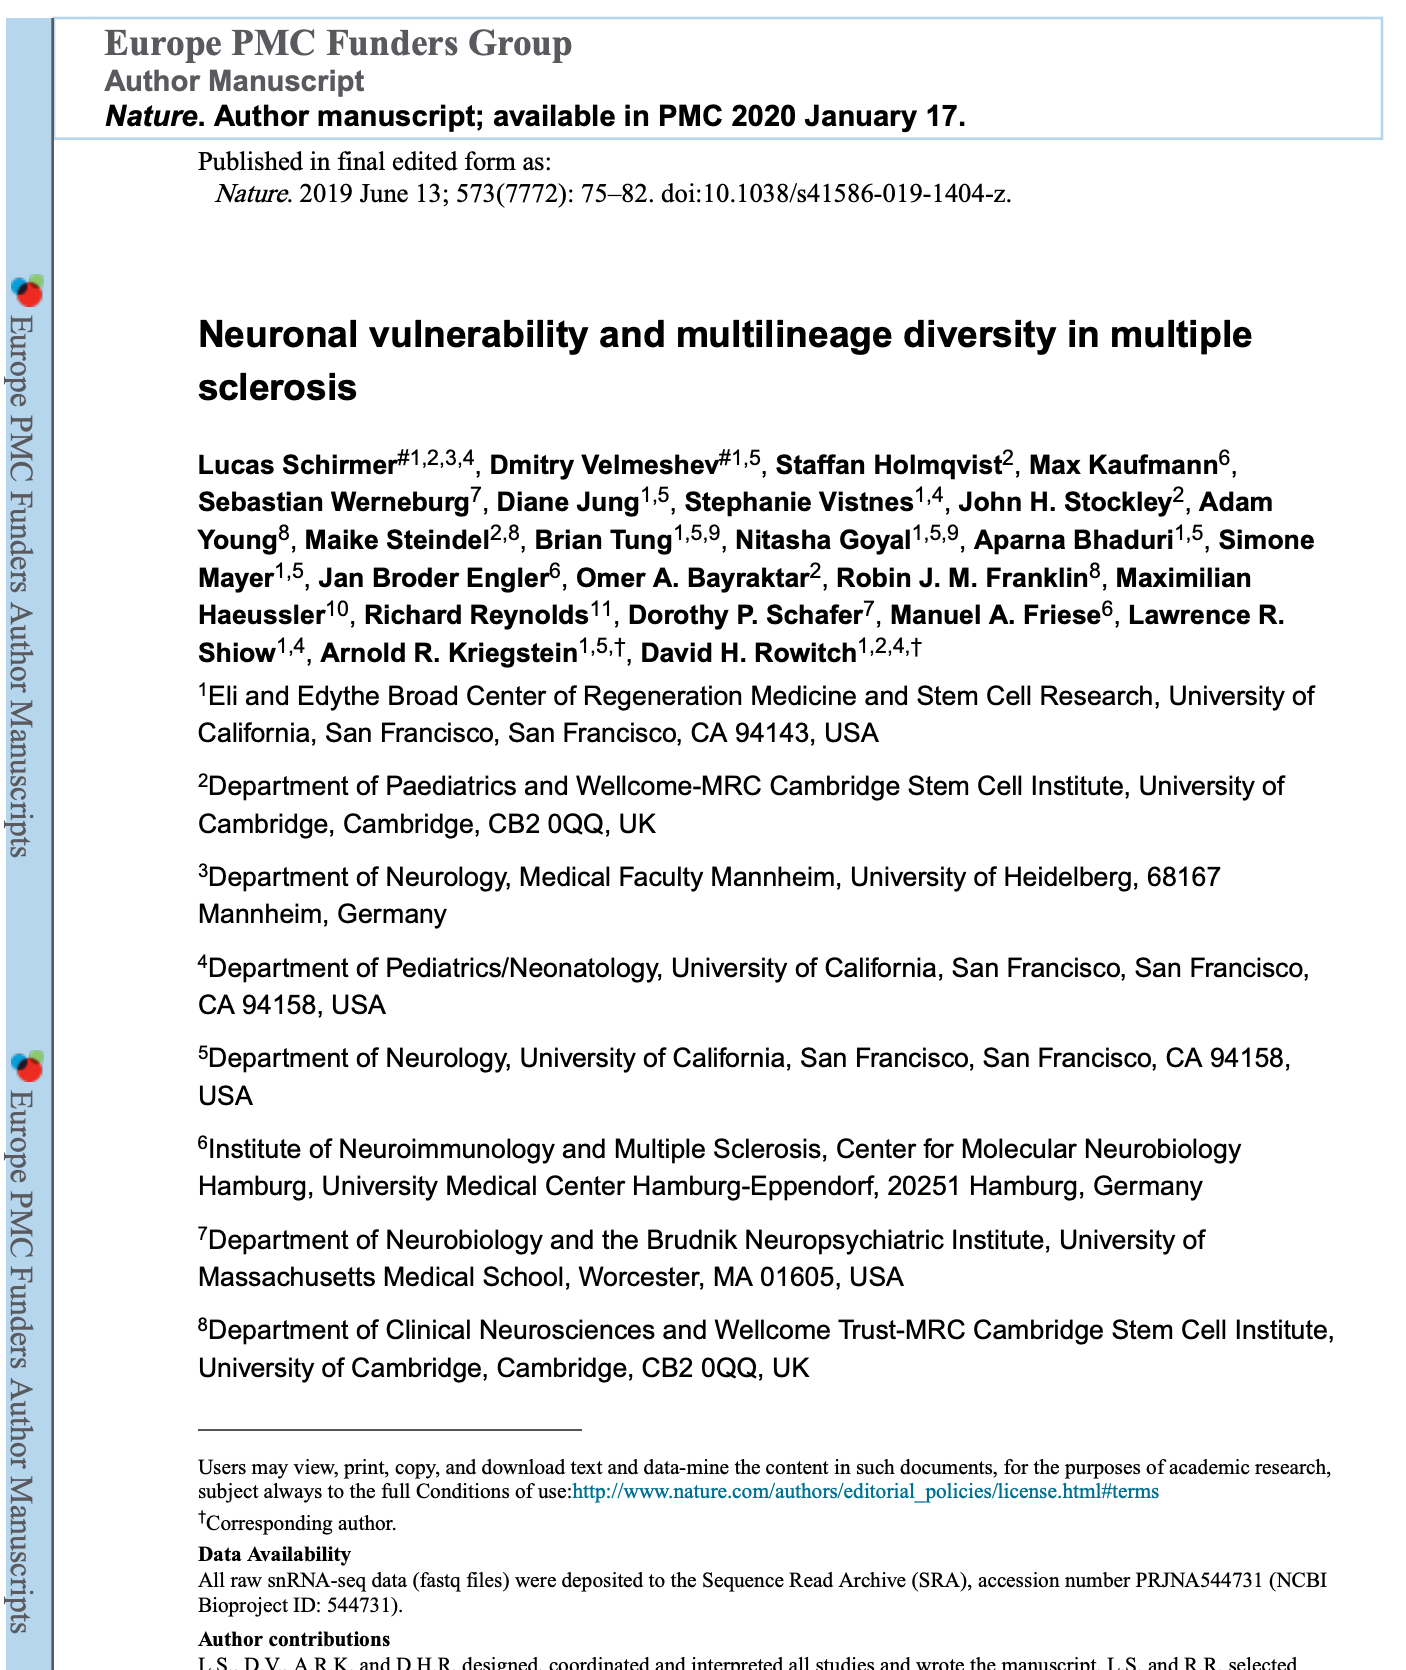

# Train

# Download CI-VAE, other necessary packages and Load Packages

In [1]:
! rm -rf ci_vae
! rm bb.pt
! rm bb_residuals.pkl
! rm df_reconstructed.csv
! rm df_reconstructed_decoder.csv
! rm residuals.pdf
! rm results_dict.pkl
! rm df_latent.csv

In [2]:
! git clone https://github.com/monabiyan/ci_vae.git
! pip install umap-learn

Cloning into 'ci_vae'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 399 (delta 71), reused 126 (delta 43), pack-reused 245
Receiving objects: 100% (399/399), 48.42 MiB | 11.16 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [3]:
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from ci_vae import ivae

In [4]:
#import umap

## Generate Input Data

Here we are generating a sample data. 

In [5]:
import numpy as np
import pandas as pd
import random
#Generate 5 random numbers between 10 and 30
np.random.seed(0)
n_samples=1000
n_features = 5
df_XY=pd.DataFrame(data = np.random.normal(0,1, size=(n_samples, n_features)), columns = ['A','B','C','D','E'])
# Cell Type
df_XY['Y']=list(np.random.randint(2, size=n_samples))
# Healthy to Cancer (State 0 to State 1)
df_XY['YY']=list(np.random.randint(2, size=n_samples))
df_XY

##############################################################   
df_XY.shape
df_XY.head()
df_XY.to_csv('df_XY.csv',index=False)
##############################################################

Alternatively you can load your custom data. But make sure the data is normalized and has to have one column 'Y' representing celltype with numbers {0,1,2,3,...} and 'YY' representing states {0,1} commonly 0 for healthy and 1 for cancer. 

In [6]:
df_XY=pd.read_csv("/Users/mnabian/Desktop/CIVAE_Studies/ms/final_data.csv")
df_XY=df_XY.drop(columns=['sample_id'])
df_XY.to_csv('df_XY.csv',index=False)
df_XY.head(n=10)
#df_XY.shape

,ENSG00000211592,ENSG00000198938,ENSG00000198712,ENSG00000198804,ENSG00000198886,ENSG00000144649,ENSG00000123560,ENSG00000173212,ENSG00000198840,ENSG00000198899,...,ENSG00000087086,ENSG00000167996,ENSG00000132639,ENSG00000169213,ENSG00000110436,ENSG00000118785,ENSG00000107317,ENSG00000197971,Y,YY
0,0.0,0.079394,0.181175,0.747515,0.000000,2.580578,0.000000,1.558536,0.000000,0.162426,...,0.000000,0.489336,1.004962,2.014817,0.000000,0.000000,0.271943,0.274084,0,0
1,0.0,0.998440,0.813722,1.918487,0.386649,1.027104,0.000000,0.876460,0.697030,0.875413,...,0.000000,0.000000,0.451364,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
2,0.0,1.007518,0.888842,1.325426,0.563123,1.171086,0.032979,1.144902,0.304551,0.522427,...,0.125625,0.576161,2.592021,0.455862,0.069126,0.000000,0.106732,0.000000,2,0
3,0.0,0.288117,0.328738,0.581292,0.781017,0.622415,0.686104,0.000000,0.000000,0.000000,...,0.871171,1.331833,2.279349,0.115627,0.479370,0.000000,1.973736,0.497319,3,0
4,0.0,0.402070,0.305839,0.180266,0.181653,1.235323,0.000000,1.406091,0.218317,0.274188,...,0.000000,0.413019,0.508940,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
5,0.0,0.046299,0.158480,0.249095,0.000000,2.467028,0.147005,1.777967,0.075418,0.000000,...,0.000000,0.071340,2.472218,1.490117,0.000000,0.154958,0.158585,0.000000,0,0
6,0.0,0.338585,0.321935,0.683115,0.229456,1.219068,0.000000,1.323981,0.000000,0.577237,...,0.000000,0.173903,1.543197,1.104901,0.187780,0.000000,0.193289,0.000000,2,0
7,0.0,0.318305,0.907958,2.568797,0.215713,0.000000,0.000000,0.000000,0.259251,1.302391,...,0.481226,0.980921,3.525448,0.000000,0.000000,0.000000,0.000000,0.000000,4,0
8,0.0,0.185097,0.105597,0.124481,0.000000,0.704752,0.000000,1.237393,0.000000,0.000000,...,0.000000,0.000000,2.635809,0.594264,0.000000,0.000000,0.000000,0.319496,5,0
9,0.0,0.000000,0.193888,0.457123,0.230320,1.957847,0.000000,1.392810,0.276806,0.347645,...,0.000000,1.047343,0.000000,2.386923,0.000000,0.000000,0.000000,0.000000,1,0


# Set Necessary Parameters 

In [7]:
model_init=True
model_tobe_trained=True
save_address="bb"
kl_coef = 0.0001
reconst_coef = 2
classifier_coef = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the Model

In [8]:
obj1 = ivae.IVAE(df_XY = df_XY,
               latent_size = 8,
               reconst_coef = reconst_coef,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

if model_init:
    obj1.model_initialiaze()

## See The Model Architecture

In [9]:
'''
print(obj1.model)
'''

'\nprint(obj1.model)\n'

## See the Initialized Weights

In [10]:
'''
for param in obj1.model.parameters():
    print(param)
'''

'\nfor param in obj1.model.parameters():\n    print(param)\n'

# RUN for Training

In [11]:
##########
if model_tobe_trained:
    lr=5e-4
    print(lr)
    obj1.model_training(epochs=60,learning_rate=lr)
    lr=1e-5
    print(lr)
    obj1.model_training(epochs=40,learning_rate=lr)
'''
    #lr=5e-4
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    #lr=5e-4
    print(lr)
    #obj.model_training(epochs=200,learning_rate=lr)

    #obj1.model_save(address=save_address+".pt")
    #obj1.save_residuals(address=save_address+'_residuals.pkl')
    #lr=5e-4
    #print(lr)
    #obj1.model_training(epochs=100,learning_rate=lr)

    #lr=5e-4
    print(lr)
    #obj1.model_training(epochs=500,learning_rate=lr)

    #obj1.model_save(address=save_address+".pt")
    #obj1.save_residuals(address=save_address+'_residuals.pkl')

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=500,learning_rate=lr)

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=500,learning_rate=lr)
'''

0.0005


/Users/mnabian/Desktop/CIVAE_Studies/ms/ci_vae/example/ci_vae/ivae.py:372: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)
/Users/mnabian/Desktop/CIVAE_Studies/ms/ci_vae/example/ci_vae/ivae.py:400: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)


====> Epoch: 1 total_train_loss: 2.216434 Total_test_loss: 1.962635 Total_BCE_test_loss: 1.640454 Total_KLD_test_loss: 0.029153 Total_CEP_test_loss: 0.293028
====> Epoch: 2 total_train_loss: 2.030931 Total_test_loss: 1.844266 Total_BCE_test_loss: 1.542207 Total_KLD_test_loss: 0.014808 Total_CEP_test_loss: 0.287251
====> Epoch: 3 total_train_loss: 1.909745 Total_test_loss: 1.764788 Total_BCE_test_loss: 1.472086 Total_KLD_test_loss: 0.008659 Total_CEP_test_loss: 0.284043
====> Epoch: 4 total_train_loss: 1.808717 Total_test_loss: 1.689319 Total_BCE_test_loss: 1.405176 Total_KLD_test_loss: 0.004914 Total_CEP_test_loss: 0.279229
====> Epoch: 5 total_train_loss: 1.724088 Total_test_loss: 1.621723 Total_BCE_test_loss: 1.340789 Total_KLD_test_loss: 0.004351 Total_CEP_test_loss: 0.276583
====> Epoch: 6 total_train_loss: 1.644130 Total_test_loss: 1.555097 Total_BCE_test_loss: 1.275683 Total_KLD_test_loss: 0.005057 Total_CEP_test_loss: 0.274358
====> Epoch: 7 total_train_loss: 1.572275 Total_test

====> Epoch: 53 total_train_loss: 1.247665 Total_test_loss: 1.223558 Total_BCE_test_loss: 0.931347 Total_KLD_test_loss: 0.048583 Total_CEP_test_loss: 0.243628
====> Epoch: 54 total_train_loss: 1.247772 Total_test_loss: 1.223305 Total_BCE_test_loss: 0.929537 Total_KLD_test_loss: 0.050242 Total_CEP_test_loss: 0.243526
====> Epoch: 55 total_train_loss: 1.245863 Total_test_loss: 1.223894 Total_BCE_test_loss: 0.929971 Total_KLD_test_loss: 0.050756 Total_CEP_test_loss: 0.243168
====> Epoch: 56 total_train_loss: 1.247821 Total_test_loss: 1.222127 Total_BCE_test_loss: 0.927889 Total_KLD_test_loss: 0.051047 Total_CEP_test_loss: 0.243191
====> Epoch: 57 total_train_loss: 1.247850 Total_test_loss: 1.223863 Total_BCE_test_loss: 0.928584 Total_KLD_test_loss: 0.052129 Total_CEP_test_loss: 0.243151
====> Epoch: 58 total_train_loss: 1.247092 Total_test_loss: 1.223711 Total_BCE_test_loss: 0.928527 Total_KLD_test_loss: 0.052302 Total_CEP_test_loss: 0.242882
====> Epoch: 59 total_train_loss: 1.246848 Tot

'\n    #lr=5e-4\n    print(lr)\n    #obj.model_training(epochs=70,learning_rate=lr)\n\n    #lr=5e-4\n    print(lr)\n    #obj.model_training(epochs=200,learning_rate=lr)\n\n    #obj1.model_save(address=save_address+".pt")\n    #obj1.save_residuals(address=save_address+\'_residuals.pkl\')\n    #lr=5e-4\n    #print(lr)\n    #obj1.model_training(epochs=100,learning_rate=lr)\n\n    #lr=5e-4\n    print(lr)\n    #obj1.model_training(epochs=500,learning_rate=lr)\n\n    #obj1.model_save(address=save_address+".pt")\n    #obj1.save_residuals(address=save_address+\'_residuals.pkl\')\n\n    lr=5e-4\n    print(lr)\n    obj1.model_training(epochs=500,learning_rate=lr)\n\n    lr=5e-4\n    print(lr)\n    obj1.model_training(epochs=500,learning_rate=lr)\n'

# Save The Trained Model

In [12]:
##########
print("running the neural network")
#run(obj1,save_address)
obj1.model_save(address=save_address+".pt")
obj1.save_residuals(address=save_address+'_residuals.pkl')

running the neural network


# Visualize Residuals

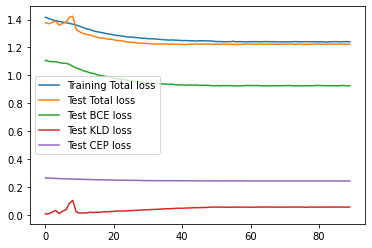

<Figure size 432x288 with 0 Axes>

In [13]:
obj1.plot_residuals(init_index=10)

# ==================================================

# Test 

# Load Model and Data

In [14]:
from ci_vae import ivae
import pandas as pd
import numpy as np
import sklearn
import torch
#import umap
import pickle
import matplotlib.pyplot as plt

In [15]:
print("start of the code")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############################################################   
##############################################################
model_init=True
model_tobe_trained=False

model_init=True
model_file_address='./bb.pt'
save_address1="./"

df_XY=pd.read_csv('df_XY.csv')
df_XY.head(n=10)

start of the code


,ENSG00000211592,ENSG00000198938,ENSG00000198712,ENSG00000198804,ENSG00000198886,ENSG00000144649,ENSG00000123560,ENSG00000173212,ENSG00000198840,ENSG00000198899,...,ENSG00000087086,ENSG00000167996,ENSG00000132639,ENSG00000169213,ENSG00000110436,ENSG00000118785,ENSG00000107317,ENSG00000197971,Y,YY
0,0.0,0.079394,0.181175,0.747515,0.000000,2.580578,0.000000,1.558536,0.000000,0.162426,...,0.000000,0.489336,1.004962,2.014817,0.000000,0.000000,0.271943,0.274084,0,0
1,0.0,0.998440,0.813722,1.918487,0.386649,1.027104,0.000000,0.876460,0.697030,0.875413,...,0.000000,0.000000,0.451364,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
2,0.0,1.007518,0.888842,1.325426,0.563123,1.171086,0.032979,1.144902,0.304551,0.522427,...,0.125625,0.576161,2.592021,0.455862,0.069126,0.000000,0.106732,0.000000,2,0
3,0.0,0.288117,0.328738,0.581292,0.781017,0.622415,0.686104,0.000000,0.000000,0.000000,...,0.871171,1.331833,2.279349,0.115627,0.479370,0.000000,1.973736,0.497319,3,0
4,0.0,0.402070,0.305839,0.180266,0.181653,1.235323,0.000000,1.406091,0.218317,0.274188,...,0.000000,0.413019,0.508940,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
5,0.0,0.046299,0.158480,0.249095,0.000000,2.467028,0.147005,1.777967,0.075418,0.000000,...,0.000000,0.071340,2.472218,1.490117,0.000000,0.154958,0.158585,0.000000,0,0
6,0.0,0.338585,0.321935,0.683115,0.229456,1.219068,0.000000,1.323981,0.000000,0.577237,...,0.000000,0.173903,1.543197,1.104901,0.187780,0.000000,0.193289,0.000000,2,0
7,0.0,0.318305,0.907958,2.568797,0.215713,0.000000,0.000000,0.000000,0.259251,1.302391,...,0.481226,0.980921,3.525448,0.000000,0.000000,0.000000,0.000000,0.000000,4,0
8,0.0,0.185097,0.105597,0.124481,0.000000,0.704752,0.000000,1.237393,0.000000,0.000000,...,0.000000,0.000000,2.635809,0.594264,0.000000,0.000000,0.000000,0.319496,5,0
9,0.0,0.000000,0.193888,0.457123,0.230320,1.957847,0.000000,1.392810,0.276806,0.347645,...,0.000000,1.047343,0.000000,2.386923,0.000000,0.000000,0.000000,0.000000,1,0


## Load Saved Model

In [16]:
obj2 = ivae.IVAE(df_XY = df_XY,
               reconst_coef = reconst_coef,
               latent_size = 8,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

obj2.model_initialiaze()

obj2.model_load(address="bb.pt")

## Print the Weights

In [17]:
'''
for param in obj2.model.parameters():
    print(param)
'''

'\nfor param in obj2.model.parameters():\n    print(param)\n'

# Make Prediction of All Test Data

In [18]:
with torch.no_grad():
    obj2.model.eval()

    obj2.load_residuals(address='bb_residuals.pkl')
    print("model loaded")
    
    obj2.generate_test_results()
    print("test data generated")

model loaded
test data generated


/Users/mnabian/Desktop/CIVAE_Studies/ms/ci_vae/example/ci_vae/ivae.py:400: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)


# Comprehensive Checking of The Prediction Values vs. True Values. 

In [19]:
'''
print(obj2.x_last)
'''

'\nprint(obj2.x_last)\n'

In [20]:
'''
print(obj2.x_pred)
'''

'\nprint(obj2.x_pred)\n'

In [21]:
'''
(np.abs(obj2.x_pred - obj2.x_last)).mean()
'''

'\n(np.abs(obj2.x_pred - obj2.x_last)).mean()\n'

In [22]:
'''
(obj2.x_pred-obj2.x_last)
'''

'\n(obj2.x_pred-obj2.x_last)\n'

In [23]:
'''
print(obj2.y_last)
'''

'\nprint(obj2.y_last)\n'

In [24]:
'''
print(obj2.y_pred)
'''

'\nprint(obj2.y_pred)\n'

In [25]:
with torch.no_grad():
    obj2.model.eval()
    for x, y in obj2.testloader:
      x = x.to(device)
      # forward
      x_hat,y_hat, mu, logvar,z = obj2.model(x)
    
    df_reconstructed = pd.DataFrame(x_hat.cpu().detach().numpy(), columns=obj1.df_XY.drop(columns=['Y']).columns)
    print(df_reconstructed.shape)
    df_latent=pd.DataFrame(z.cpu().detach().numpy())
    
    obj2.model.eval()
    
    df_reconstructed_decoder=pd.DataFrame(obj2.model.decoder(z).cpu().detach().numpy(), columns=obj1.df_XY.drop(columns=['Y']).columns)

    df_reconstructed.to_csv('df_reconstructed.csv')
    df_latent.to_csv('df_latent.csv')
    df_reconstructed_decoder.to_csv('df_reconstructed_decoder.csv')
    print("Full_data_reconstructed...")
    '''
    print("========df_reconstructed========")
    print(df_reconstructed)
    print("========df_reconstructed_decoder========")
    print(df_reconstructed_decoder)
    print("========df_Original========")
    print(df_XY)
     '''
    
    


(21468, 30)
Full_data_reconstructed...


# Checking Linear Separability of Data on Lower Dimensioanl Space

In [26]:
print("regression analysis")
obj2.regression_analysis(obj2.zs,df_XY['Y'])

regression analysis
0.3140022358859698


# Visualize Data on Lower Dimensional Space

In [27]:
'''
print("calculate tsne_umap_pca")
tsne_mat,umap_mat,pca_mat,Y=obj2.calculate_lower_dimensions(obj2.zs,obj2.y_last,N=100)
obj2.plot_lower_dimension(tsne_mat,Y,projection='3d',save_str='tsne3d.pdf')
obj2.plot_lower_dimension(tsne_mat,Y,projection='2d',save_str='tsne2d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='3d',save_str='umap3d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='2d',save_str='umap2d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='3d',save_str='pca3d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='2d',save_str='pca2d.pdf')

print("finished")
'''

'\nprint("calculate tsne_umap_pca")\ntsne_mat,umap_mat,pca_mat,Y=obj2.calculate_lower_dimensions(obj2.zs,obj2.y_last,N=100)\nobj2.plot_lower_dimension(tsne_mat,Y,projection=\'3d\',save_str=\'tsne3d.pdf\')\nobj2.plot_lower_dimension(tsne_mat,Y,projection=\'2d\',save_str=\'tsne2d.pdf\')\nobj2.plot_lower_dimension(umap_mat,Y,projection=\'3d\',save_str=\'umap3d.pdf\')\nobj2.plot_lower_dimension(umap_mat,Y,projection=\'2d\',save_str=\'umap2d.pdf\')\nobj2.plot_lower_dimension(pca_mat,Y,projection=\'3d\',save_str=\'pca3d.pdf\')\nobj2.plot_lower_dimension(pca_mat,Y,projection=\'2d\',save_str=\'pca2d.pdf\')\n\nprint("finished")\n'

# Perform Interpolation across all groups (Y) and all features from YY=0 to YY=1

In [28]:
ff = obj2.traversal_all_groups(traversal_step=10)

0
997 1732
[[-7.71278314e-06  2.64516056e-01  2.50981562e-01  3.26664746e-01
   2.86438391e-01  1.22665733e+00  5.42951284e-06  1.70621645e+00
   1.90691441e-01  2.26204008e-01  1.90135860e+00  5.10401726e-01
   2.78268322e-01  2.47009099e-01  2.00170234e-01  2.11351529e-01
   2.55706802e-01  9.85445142e-01 -6.08957635e-06  9.24639672e-01
   3.17771047e-01  1.25030738e+00  9.48501453e-02  2.56139353e-01
   1.07604879e+00  1.00373724e+00  2.12626904e-03  5.87889372e-06
   4.81019542e-03  2.29252316e-03]
 [-7.10892414e-06  2.75733933e-01  2.58536369e-01  3.41315851e-01
   2.97769904e-01  1.21377093e+00  4.71027124e-06  1.68468082e+00
   1.99890934e-01  2.38968104e-01  1.86100894e+00  5.35175025e-01
   2.93316960e-01  2.60615826e-01  2.12196559e-01  2.22862184e-01
   2.67134383e-01  9.56150353e-01 -6.01378269e-06  9.05903190e-01
   3.16228986e-01  1.23742992e+00  9.83098298e-02  2.55119830e-01
   1.09555089e+00  9.77202088e-01  2.04076711e-03  5.35082449e-06
   4.75672632e-03  2.29961984e

[[-7.78636513e-06  2.44282290e-01  2.35458672e-01  3.00217807e-01
   2.66985834e-01  1.23010439e+00  5.70875090e-06  1.74185729e+00
   1.73918851e-01  2.05941767e-01  1.96650642e+00  4.67506215e-01
   2.67221898e-01  2.21735999e-01  1.90695986e-01  1.90515235e-01
   2.32907295e-01  1.03636640e+00 -6.12752046e-06  9.58266437e-01
   3.18422854e-01  1.25475383e+00  9.36559588e-02  2.55988866e-01
   1.03850436e+00  1.04792708e+00  2.04777438e-03  6.10398138e-06
   4.75040078e-03  2.28524767e-03]
 [-7.40332712e-06  2.66107023e-01  2.51336277e-01  3.28728855e-01
   2.88190067e-01  1.22285426e+00  5.02202647e-06  1.70271838e+00
   1.91830851e-01  2.28412770e-01  1.89470017e+00  5.14038086e-01
   2.82688797e-01  2.48561680e-01  2.02146828e-01  2.12928027e-01
   2.56567776e-01  9.81220990e-01 -6.05137757e-06  9.21941936e-01
   3.15953851e-01  1.24692476e+00  9.70956609e-02  2.54541934e-01
   1.07773197e+00  9.99427497e-01  2.00525019e-03  5.71391911e-06
   4.73959371e-03  2.29866803e-03]
 [-6.8

[[-7.87309455e-06  8.43894660e-01  7.92082816e-01  9.17066157e-01
   8.67902696e-01  1.04537749e+00 -2.52984728e-06  1.31679207e+00
   6.47299320e-01  7.72859603e-01  1.18474597e+00  1.04523510e+00
   9.18699324e-01  7.91068673e-01  5.54948211e-01  5.84052503e-01
   8.34356308e-01  4.69239503e-01 -1.04864739e-06  4.70621228e-01
   3.57218057e-01  1.02803415e+00  1.35647163e-01  2.70880282e-01
   1.39545965e+00  4.85591307e-01  1.58880278e-03 -1.12206499e-05
   4.18759510e-03  2.32884660e-03]
 [-9.42086535e-06  9.28676605e-01  8.65721673e-01  1.00357348e+00
   9.49859381e-01  1.03491038e+00 -2.52413929e-06  1.29231381e+00
   7.21299946e-01  8.63806367e-01  1.16295707e+00  1.06711459e+00
   9.95787412e-01  8.71950626e-01  6.04444772e-01  6.42662704e-01
   9.18774575e-01  4.48546946e-01 -1.45949889e-06  4.47190389e-01
   3.64399552e-01  1.01876676e+00  1.34207450e-01  2.73062140e-01
   1.39559954e+00  4.63902354e-01  1.59490854e-03 -1.37202187e-05
   4.17989865e-03  2.32486986e-03]
 [-1.1

[[-7.56173085e-06  2.97420144e-01  2.74713159e-01  3.69655460e-01
   3.18970948e-01  1.19713002e+00  3.44043974e-06  1.64571917e+00
   2.17690907e-01  2.61276528e-01  1.78984559e+00  5.81501603e-01
   3.18935230e-01  2.87466303e-01  2.33606435e-01  2.45166093e-01
   2.91243404e-01  9.01182830e-01 -6.10386633e-06  8.69826436e-01
   3.15623879e-01  1.21745872e+00  1.02571815e-01  2.54138395e-01
   1.13498467e+00  9.28968370e-01  2.09827069e-03  4.32650381e-06
   4.76351008e-03  2.28559598e-03]
 [-7.13611257e-06  2.87951663e-01  2.68419683e-01  3.57293949e-01
   3.09293196e-01  1.20732301e+00  4.04630805e-06  1.66393286e+00
   2.10049100e-01  2.50574335e-01  1.82370365e+00  5.60479909e-01
   3.06502298e-01  2.76120082e-01  2.23488726e-01  2.35468656e-01
   2.81649515e-01  9.26062942e-01 -6.11911673e-06  8.85673881e-01
   3.14431354e-01  1.22780222e+00  1.00893781e-01  2.53456607e-01
   1.11887556e+00  9.51419115e-01  2.10669264e-03  4.76502237e-06
   4.77001816e-03  2.29382142e-03]
 [-6.7

[[-7.86744749e-06  2.26420462e-01  2.23914072e-01  2.76895791e-01
   2.49509215e-01  1.25577962e+00  7.63137814e-06  1.77396035e+00
   1.59506693e-01  1.87628001e-01  2.02527380e+00  4.29027021e-01
   2.33933032e-01  2.00342134e-01  1.62884116e-01  1.72220528e-01
   2.14979410e-01  1.08203197e+00 -6.32033334e-06  9.88136172e-01
   3.14619243e-01  1.28416288e+00  8.57614130e-02  2.51821935e-01
   1.00838673e+00  1.08770835e+00  2.09182501e-03  7.67141591e-06
   4.79804724e-03  2.28229910e-03]
 [-7.81410381e-06  2.27710694e-01  2.23499730e-01  2.78568923e-01
   2.50507578e-01  1.25537854e+00  7.59157365e-06  1.77274776e+00
   1.60372525e-01  1.88329645e-01  2.02298176e+00  4.31605533e-01
   2.34668516e-01  2.01349035e-01  1.63565569e-01  1.73492566e-01
   2.14829788e-01  1.07894802e+00 -6.31465082e-06  9.85900760e-01
   3.14206362e-01  1.28426868e+00  8.57328363e-02  2.52449423e-01
   1.00851017e+00  1.08615041e+00  2.09946465e-03  7.62402851e-06
   4.80733067e-03  2.28254125e-03]
 [-7.7

[[-4.63750257e-06  2.99131900e-01  2.76571393e-01  3.71899068e-01
   3.20292532e-01  1.19804275e+00  3.38119321e-06  1.64361918e+00
   2.19209403e-01  2.62225538e-01  1.78634226e+00  5.84646165e-01
   3.19884032e-01  2.89835811e-01  2.34707370e-01  2.46953845e-01
   2.93727428e-01  8.97399366e-01 -6.07015681e-06  8.67028356e-01
   2.96684891e-01  1.21744490e+00  1.03676543e-01  2.40254521e-01
   1.13892484e+00  9.26278234e-01  1.70026347e-03  4.23841902e-06
   4.40232456e-03  2.31912732e-03]
 [-4.46763875e-06  3.02894518e-01  2.79218107e-01  3.76814365e-01
   3.24052542e-01  1.19447470e+00  3.14898546e-06  1.63658863e+00
   2.22284585e-01  2.66330242e-01  1.77334362e+00  5.92836112e-01
   3.24659780e-01  2.94433683e-01  2.38599479e-01  2.50817508e-01
   2.97722831e-01  8.87699306e-01 -6.04910019e-06  8.60754639e-01
   2.96596944e-01  1.21350652e+00  1.04735013e-01  2.40319334e-01
   1.14557034e+00  9.17599350e-01  1.68139674e-03  4.06168829e-06
   4.38579544e-03  2.32111849e-03]
 [-4.6

[[-5.59242153e-06  3.50022182e-01  3.26187670e-01  4.27517042e-01
   3.71086419e-01  1.16398466e+00  9.90317744e-07  1.56949419e+00
   2.67365769e-01  3.20665717e-01  1.63525385e+00  6.90016657e-01
   3.94172475e-01  3.46740171e-01  2.74843439e-01  2.85470098e-01
   3.47098187e-01  7.92125285e-01 -5.21405309e-06  7.90992945e-01
   3.03134859e-01  1.16988862e+00  1.17732912e-01  2.52397597e-01
   1.21843791e+00  8.31065834e-01  1.72502920e-03  2.06829736e-06
   4.40980121e-03  2.31967680e-03]
 [-4.91279820e-06  3.73744473e-01  3.50667775e-01  4.53309327e-01
   3.93029273e-01  1.14545697e+00  3.43551392e-08  1.53325450e+00
   2.94790179e-01  3.51948261e-01  1.56921279e+00  7.42382050e-01
   4.34714481e-01  3.71455073e-01  2.88951486e-01  2.98687786e-01
   3.69953468e-01  7.48514593e-01 -4.18731361e-06  7.57507890e-01
   3.00628588e-01  1.14936447e+00  1.24112137e-01  2.51938313e-01
   1.24633861e+00  7.86691010e-01  1.73358619e-03  1.12276268e-06
   4.41394001e-03  2.32609361e-03]
 [-4.3

/Users/mnabian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mnabian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/mnabian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnabian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/mnabian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/mnabian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.


# See the interpolation results

In [29]:
with open('results_dict.pkl', 'rb') as f:
    ff = pickle.load(f)

In [30]:
'''
ff['med']['0']
'''

"\nff['med']['0']\n"

In [31]:
'''
ff['mean']['1']
'''

"\nff['mean']['1']\n"

## Interactive Plot

In [32]:
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
def plot_path_prediction(celltypes, genes):
    # generate plot based on a and b
    yy=ff['mean'][celltypes][genes].tolist()
    xx=list(range(1,len(yy)+1))
    
    plt.plot(xx,yy)
        
    mark_s=100
    plt.scatter(xx[0],yy[0],  marker='*', c='g', s=mark_s)
    plt.scatter(xx[-1],yy[-1], marker='*', c='r', s=mark_s)
    
    plt.xticks(range(min(xx), max(xx)+1))
    plt.xlabel('healthy to cancer')
    plt.ylabel('normalized gene expression')
    plt.title('Predicted Linear interpolation for cell-type '+celltypes+" for gene "+genes)
    plt.show()
    
    gg=df_XY.groupby(['Y','YY']).mean().reset_index(drop=False)
    gg=gg.loc[gg['Y']==int(celltypes),:].sort_values('YY',ascending='True')
    
    xx=gg['YY'].tolist()
    yy=gg[genes].tolist()
    
    plt.plot(xx,yy,'--',color='green')
    plt.scatter(xx,yy,  marker='*', c='b', s=mark_s)
    plt.scatter(xx[0],yy[0],  marker='*', c='g', s=mark_s)
    plt.scatter(xx[-1],yy[-1], marker='*', c='r', s=mark_s)
    
    plt.xlabel('healthy to cancer')
    plt.ylabel('normalized gene expression')
    plt.title('True Trajectory for cell-type '+celltypes+" for gene "+genes)
    plt.show()
    

# get the list of possible values for a and b
a_values = list(set(obj2.df_XY['Y']))
a_values = list(map(str, a_values))
b_values = obj2.df_XY.columns.tolist()[:-1]

from IPython.display import display

# create the dropdown widgets
a_widget = Dropdown(options=a_values)
b_widget = Dropdown(options=b_values)

# use the interact function to bind the widgets and the function
output1 = interact(plot_path_prediction, celltypes=a_widget, genes=b_widget)

# display the output in an HTML page
display(output1)

#output2 = interact(plot_path_truth, celltypes=a_widget, genes=b_widget)

# display the output in an HTML page
#display(output2)

interactive(children=(Dropdown(description='celltypes', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', …

<function __main__.plot_path_prediction(celltypes, genes)>

In [39]:
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
def plot_heatmap(celltypes):
    ddff=ff['mean'][celltypes]
    from scipy.ndimage import rotate
    fig, ax = plt.subplots()
    plt.imshow(ddff, cmap='YlOrRd')
    plt.colorbar()
    # Set the y-axis tick labels to the column names
    ax.xaxis.tick_top()
    plt.xticks(range(len(ddff.columns)), ddff.columns)

    # Rotate the y-axis tick labels 90 degrees
    plt.setp(plt.gca().get_xticklabels(), rotation=90)

    # Set the font size of the y-axis tick labels
    plt.tick_params(axis='x', which='major', labelsize='x-small')

    plt.yticks(range(ddff.shape[0]))
    plt.tick_params(axis='y', which='major', labelsize='x-small')
    #plt.figure(figsize=(40, 40))

    plt.ylabel('healthy \n to \n cancer',rotation=90)
    # Add an arrow to the y-axis label
    plt.show()
    

# get the list of possible values for a and b
a_values = list(set(obj2.df_XY['Y']))
a_values = list(map(str, a_values))


from IPython.display import display

# create the dropdown widgets
a_widget = Dropdown(options=a_values)


# use the interact function to bind the widgets and the function
output1 = interact(plot_heatmap, celltypes=a_widget)

# display the output in an HTML page
display(output1)

#output2 = interact(plot_path_truth, celltypes=a_widget, genes=b_widget)

# display the output in an HTML page
#display(output2)

interactive(children=(Dropdown(description='celltypes', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', …

<function __main__.plot_heatmap(celltypes)>

In [34]:
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt

def plot_path_prediction(celltypes, gene1,gene2):
    # generate plot based on a and b
    xx=ff['mean'][celltypes][gene1].tolist()
    yy=ff['mean'][celltypes][gene2].tolist()
    plt.plot(xx,yy)
    
    mark_s=100
    plt.scatter(xx[0], yy[0], marker='*', c='g', s=mark_s)
    plt.scatter(xx[-1], yy[-1], marker='*', c='r', s=mark_s)
    
    plt.xlabel(gene1)
    plt.ylabel(gene2)
    plt.title('Predicted Linear interpolation for cell-type '+celltypes+" for gene "+gene1+' && '+gene2)
    plt.show()
    #################################
    #################################
    gg=df_XY.groupby(['Y','YY']).mean().reset_index(drop=False)
    gg=gg.loc[gg['Y']==int(celltypes),:].sort_values('YY',ascending='True')
    
    xx=gg[gene1].tolist()
    yy=gg[gene2].tolist()
    
    plt.plot(xx,yy,'--',color='green')
    plt.scatter(xx[0], yy[0], marker='*', c='g', s=mark_s)
    plt.scatter(xx[-1], yy[-1], marker='*', c='r', s=mark_s)
    
    plt.xlabel(gene1)
    plt.ylabel(gene2)
    plt.title('True Trajectory for cell-type '+celltypes+" for gene "+gene1+' && '+gene2)
    plt.show()
    

# get the list of possible values for a and b
a_values = list(set(obj2.df_XY['Y']))
a_values = list(map(str, a_values))
b_values = obj2.df_XY.columns.tolist()[:-1]
c_values = obj2.df_XY.columns.tolist()[:-1]

from IPython.display import display

# create the dropdown widgets
a_widget = Dropdown(options=a_values)
b_widget = Dropdown(options=b_values)
c_widget = Dropdown(options=c_values)

# use the interact function to bind the widgets and the function
output1 = interact(plot_path_prediction, celltypes=a_widget, gene1=b_widget,gene2=c_widget)

# display the output in an HTML page
display(output1)

#output2 = interact(plot_path_truth, celltypes=a_widget, genes=b_widget)

# display the output in an HTML page
#display(output2)

interactive(children=(Dropdown(description='celltypes', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', …

<function __main__.plot_path_prediction(celltypes, gene1, gene2)>

# Generate Synthetic Data for a Given Class

In [35]:
synt_data = obj2.synthetic_single_group(group_id=0,nr_of_synthetic=1000)
print(synt_data.shape)

2729 2729
(1000, 30)


In [36]:
synt_data

array([[-2.71442877e-05,  1.89379406e+00,  1.71676457e+00, ...,
        -4.22970115e-05,  4.25662845e-03,  2.25507841e-03],
       [-2.20210386e-05,  1.64506543e+00,  1.49201977e+00, ...,
        -3.50375412e-05,  4.08159941e-03,  2.26511434e-03],
       [-1.75061468e-05,  1.41515803e+00,  1.28677702e+00, ...,
        -2.82597684e-05,  4.00225073e-03,  2.27786973e-03],
       ...,
       [-1.94546374e-06,  4.56637979e-01,  4.27975178e-01, ...,
        -1.35063601e-06,  5.08326292e-03,  2.37439573e-03],
       [-2.25818508e-06,  4.27734137e-01,  3.99489224e-01, ...,
        -3.86079790e-07,  4.76947427e-03,  2.37745792e-03],
       [-2.45286492e-06,  3.86112571e-01,  3.61851931e-01, ...,
         6.63793287e-07,  4.67955321e-03,  2.36846134e-03]])